In [25]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Import Data

In [2]:
%time df = pd.read_csv('../data/twcs.csv')

CPU times: user 4.39 s, sys: 424 ms, total: 4.82 s
Wall time: 4.82 s


## EDA

In [3]:
df.shape

(1904290, 7)

In [4]:
df.columns.tolist()

['tweet_id',
 'author_id',
 'inbound',
 'created_at',
 'text',
 'response_tweet_id',
 'in_response_to_tweet_id']

In [5]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sainsburys,False,Fri Nov 03 19:56:25 +0000 2017,@83897 ...He'll pass your thanks on to them an...,NaN,2.0
1,2,83897,True,Thu Nov 02 19:52:44 +0000 2017,@sainsburys Sorry no. It was the staff on at t...,"1,3",4.0
2,4,sainsburys,False,Thu Nov 02 19:15:01 +0000 2017,@83897 How nice! Did you catch their name at a...,2,5.0
3,5,83897,True,Thu Nov 02 13:08:24 +0000 2017,Lovely friendly staff @sainsburys cafe Bretton...,4,NaN
4,6,sainsburys,False,Fri Nov 03 19:51:06 +0000 2017,@83898 Oh no! Sorry about that Tom. Could you ...,7,8.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904290 entries, 0 to 1904289
Data columns (total 7 columns):
tweet_id                   int64
author_id                  object
inbound                    bool
created_at                 object
text                       object
response_tweet_id          object
in_response_to_tweet_id    float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 89.0+ MB


In [7]:
#%time df['date'] = pd.to_datetime(df.created_at)

CPU times: user 5min 59s, sys: 12 ms, total: 5min 59s
Wall time: 5min 59s


In [9]:
#df.to_pickle('../data/tweets.pkl')

## Import Pickle

In [7]:
df = pd.read_pickle('../data/tweets.pkl')

In [8]:
df.drop('created_at',axis=1,inplace=True)

In [9]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date
0,1,sainsburys,False,@83897 ...He'll pass your thanks on to them an...,NaN,2.0,2017-11-03 19:56:25
1,2,83897,True,@sainsburys Sorry no. It was the staff on at t...,"1,3",4.0,2017-11-02 19:52:44
2,4,sainsburys,False,@83897 How nice! Did you catch their name at a...,2,5.0,2017-11-02 19:15:01
3,5,83897,True,Lovely friendly staff @sainsburys cafe Bretton...,4,NaN,2017-11-02 13:08:24
4,6,sainsburys,False,@83898 Oh no! Sorry about that Tom. Could you ...,7,8.0,2017-11-03 19:51:06


In [10]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date
0,1,sainsburys,False,@83897 ...He'll pass your thanks on to them an...,NaN,2.0,2017-11-03 19:56:25
1,2,83897,True,@sainsburys Sorry no. It was the staff on at t...,"1,3",4.0,2017-11-02 19:52:44
2,4,sainsburys,False,@83897 How nice! Did you catch their name at a...,2,5.0,2017-11-02 19:15:01
3,5,83897,True,Lovely friendly staff @sainsburys cafe Bretton...,4,NaN,2017-11-02 13:08:24
4,6,sainsburys,False,@83898 Oh no! Sorry about that Tom. Could you ...,7,8.0,2017-11-03 19:51:06


In [11]:
df['month'] = df.date.dt.month

### Tweets by Month

In [12]:
df.inbound.value_counts()

True     1038443
False     865847
Name: inbound, dtype: int64

In [13]:
inboundDF = df[df.inbound == True]

In [14]:
inboundDF.shape

(1038443, 8)

In [20]:
monthGroup = df.groupby('month').inbound.count().reset_index()

In [21]:
monthGroup

,month,inbound
0,1,279
1,2,318
2,3,257
3,4,408
4,5,505
5,6,545
6,7,880
7,8,2046
8,9,12812
9,10,1252713


Text(0,0.5,'Inbound Tweets')

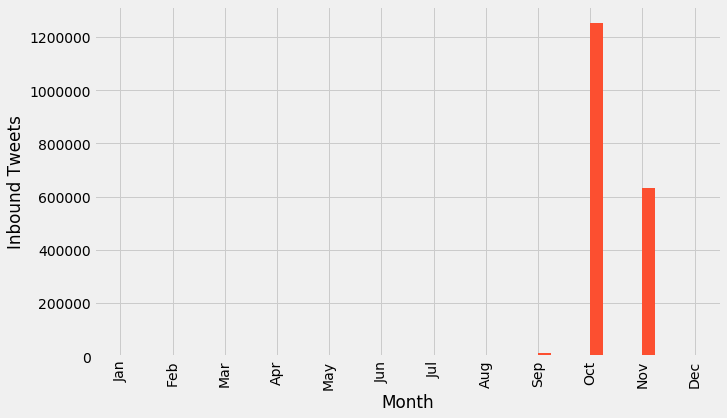

In [34]:
month_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(12),month_ticks)
plt.xlabel('Month')
plt.ylabel('Inbound Tweets')

### Tweets by Day

In [37]:
df['day'] = df.date.dt.dayofweek

In [39]:
dayGroup = df.groupby('day').inbound.count().reset_index()

Text(0,0.5,'Inbound Tweets')

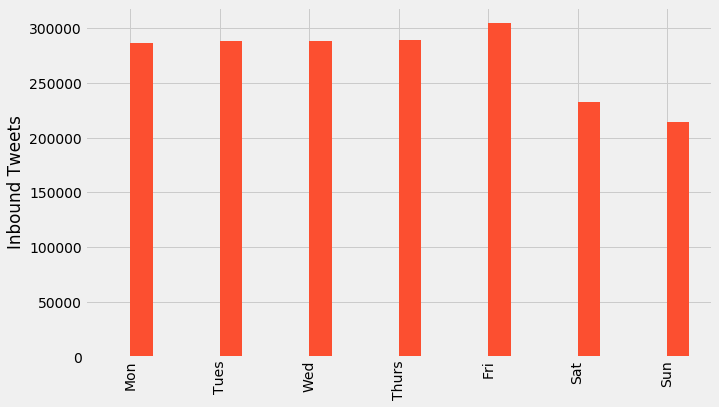

In [45]:
day_ticks = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
dayGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(7),day_ticks)
#plt.xlabel('Day')
plt.ylabel('Inbound Tweets')

### Tweets by Company

ValueError: max must be larger than min in range parameter.

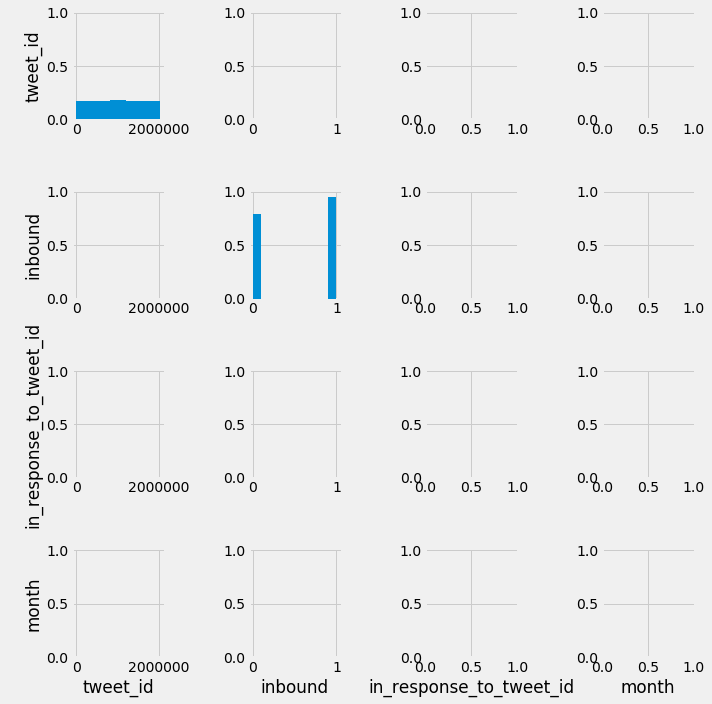